In [8]:
from std_methods import std_methods

tickers = ['AAPL','JPM','F','PG', 'BA']

equal_weights,min_risk,risk_parity = std_methods(tickers,'1992-01-01','2022-18-31','2023-01-01','2023-12-31')

from enviroments.benchmark import create_env_benchmark


investment_period = 1 # each 1 investment days 
reward_period = 15 # each 15 investment periods
eval_env,eval_dates,eval_benchmark,prices = create_env_benchmark(tickers,'2023-01-01','2023-12-31',investment_period,reward_period)

[7.95985831e-12 3.45395956e-11 9.47447097e-01 5.09396416e-02
 1.61326095e-03]
[0.02270654 0.0285299  0.9138212  0.03045487 0.00448748]


In [9]:

import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import SAC
from DSAC import DSAC

def evaluate_model(model,env):
    done = False
    rewards = []
    portfolio_worths = []
    obs = env.reset()
    portfolio_worths.append(1.0)
    drawdowns = []
    max_worth = 1.0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done,info = env.step(action)
        portfolio_worths.append(info[0]['porfolio_worth'])
        max_worth = max(max_worth,info[0]['porfolio_worth'])
        drawdown = (max_worth - info[0]['porfolio_worth'])
        drawdowns.append(drawdown)
        rewards.append(reward)
    return np.array(rewards),np.array(portfolio_worths),np.array(drawdowns)


def extract_portfolio(eval_env, eval_benchmark, model):
    rewards,portfolio_worths,drawdowns = evaluate_model(model,eval_env)
    monthly_portfolio_worths = portfolio_worths[::25]
    monthly_portfolio_returns = np.diff(monthly_portfolio_worths)/monthly_portfolio_worths[:-1]
    sharpe_ratio = np.mean(monthly_portfolio_returns)/np.std(monthly_portfolio_returns)
    
    monthly_benchmark_worths = eval_benchmark[::25]
    monthly_benchmark_returns = np.diff(monthly_benchmark_worths)/monthly_benchmark_worths[:-1]
    excess_returns = monthly_portfolio_returns - monthly_benchmark_returns
    information_ratio = np.mean(excess_returns)/np.std(excess_returns)
    max_drawdown = np.max(drawdowns)
    
    return portfolio_worths,sharpe_ratio,information_ratio,max_drawdown

def evaluate_SAC(model_path):
    model = SAC.load(f'./models/{model_path}.zip')
        
    portfolio_worths,sharpe_ratio,information_ratio,max_drawdown = extract_portfolio(eval_env, eval_benchmark, model)
    return portfolio_worths,sharpe_ratio,information_ratio,max_drawdown


def evaluate_DSAC(model_path):
    bare_model = DSAC(policy='MlpPolicy', env=eval_env, verbose=1)
    bare_model.set_parameters(f'./models/{model_path}.zip')
    
    portfolio_worths,sharpe_ratio,information_ratio,max_drawdown = extract_portfolio(eval_env, eval_benchmark, bare_model)
    return portfolio_worths,sharpe_ratio,information_ratio,max_drawdown


paper Sharpe Ratio: 0.0660169351874154,  Information Ratio: -0.18598381195932664, Final Portfolio Worth: 1.0977869585348892, Max Drawdown: 0.1598851199991147


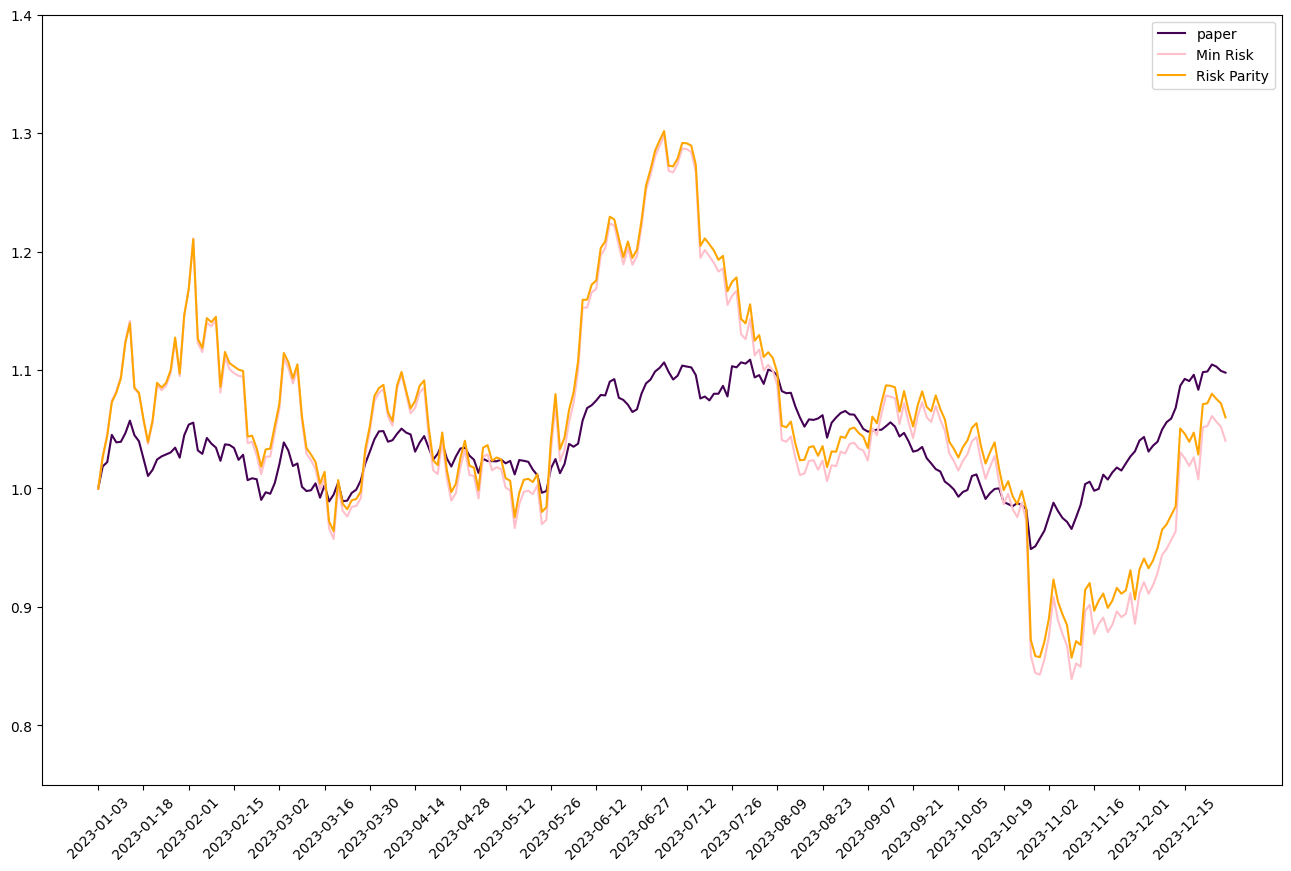

In [21]:
models = {
    'paper': 'paper',
}

plt.figure(figsize=(16,10))
i = 0

for model_name,model_path in models.items():
    if 'DSAC' in model_path:
        portfolio_worths, sharpe_ratio, information_ratio, max_drawdown = evaluate_DSAC(model_path)
    else:
        portfolio_worths, sharpe_ratio, information_ratio, max_drawdown = evaluate_SAC(model_path)
    print(f'{model_name} Sharpe Ratio: {sharpe_ratio},  Information Ratio: {information_ratio}, Final Portfolio Worth: {portfolio_worths[-1]}, Max Drawdown: {max_drawdown}')
    
    plt.plot(eval_dates,portfolio_worths, linestyle='-',label=f'{model_name}', color = plt.cm.viridis(i/len(models)))
    i += 1
    
eval_benchmark_relative = eval_benchmark/eval_benchmark[0]

plt.plot(eval_dates,min_risk, label='Min Risk', color='pink')
plt.plot(eval_dates,risk_parity, label='Risk Parity', color='orange')

plt.xticks(eval_dates[::(len(eval_dates)//25)],rotation=45)
plt.ylim(0.75,1.4)
plt.legend()